# Project 1: Digit Classification with KNN and Naive Bayes

In this project, you'll implement your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but <b> please prepare your own write-up (with your own code). </b>

If you're interested, check out these links related to digit recognition:

* Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/
* Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

Finally, if you'd like to get started with Tensorflow, you can read through this tutorial: https://www.tensorflow.org/tutorials/keras/basic_classification. It uses a dataset called "fashion_mnist", which is identical in structure to the original digit mnist, but uses images of clothing rather than images of digits. The number of training examples and number of labels is the same. In fact, you can simply replace the code that loads "fashion_mnist" with "mnist" and everything should work fine.

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from scipy.ndimage import gaussian_filter
from functools import reduce

# Set the randomizer seed so results are the same each time.
np.random.seed(0)


Bad key "text.kerning_factor" on line 4 in
C:\Users\sarahwang\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
import sklearn
sklearn.__version__

'0.20.1'

Load the data. Notice that the data gets partitioned into training, development, and test sets. Also, a small subset of the training data called mini_train_data and mini_train_labels gets defined, which you should use in all the experiments below, unless otherwise noted.

In [3]:
# Load the digit data from https://www.openml.org/d/554 or from default local location '~/scikit_learn_data/...'
X, Y = fetch_openml(name='mnist_784', return_X_y=True, cache=False)


# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print('data shape: ', X.shape)
print('label shape:', Y.shape)

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

data shape:  (70000, 784)
label shape: (70000,)


In [4]:
mini_train_data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Part 1:

Show a 10x10 grid that visualizes 10 examples of each digit.

Notes:
* You can use `plt.rc()` for setting the colormap, for example to black and white.
* You can use `plt.subplot()` for creating subplots.
* You can use `plt.imshow()` for rendering a matrix.
* You can use `np.array.reshape()` for reshaping a 1D feature vector into a 2D matrix (for rendering).

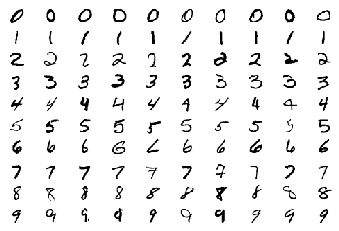

In [5]:
#def P1(num_examples=10):

### STUDENT START ###

def calc_digit_indices(digit,num_examples):
    """
    Generate a random sample of size num_examples without replacement
    
    Args:
        digit: the digit that needs to visualized, from 0 to 9
        num_examples: default as 10
    Return:
        An array of length of num_examples that represents indices of given digit in mini_train_labels
        
    """
    return np.random.choice(a=np.flatnonzero(mini_train_labels==digit),
                         size=num_examples,replace=False)
    
def P1(num_examples=10):
    """
    Plot 10x10 grid that visualizes 10 examples of each digit
    
    Args:
        num_examples: the number of digits to be plotted
    
    Returns:
        A 10x10 grid which visualizes 10 examples of each digit.
    """
    
    
    digit_index={int(digit):calc_digit_indices(digit,num_examples)
                 for digit in np.unique(mini_train_labels)}

    figure, axes = plt.subplots(nrows=len(digit_index.keys()),
                             ncols=num_examples)

    for key in digit_index.keys():
        for num in range(num_examples):
            idx = digit_index[key][num]
            data = mini_train_data[idx].reshape(28,28)
            axes[key][num].imshow(data,cmap='Greys')
            axes[key][num].axis('off') 
    plt.show()
    
P1(10) 


### STUDENT END ###

#P1(10)

### Part 2:

Produce k-Nearest Neighbors models with k $\in$ [1,3,5,7,9].  Evaluate and show the accuracy of each model. For the 1-Nearest Neighbor model, additionally show the precision, recall, and F1 for each label. Which digit is the most difficult for the 1-Nearest Neighbor model to recognize?

Notes:
* Train on the mini train set.
* Evaluate performance on the dev set.
* You can use `KNeighborsClassifier` to produce a k-nearest neighbor model.
* You can use `classification_report` to get precision, recall, and F1 results.

In [6]:
#def P2(k_values):

### STUDENT START ###
def P2(k_values):
    """
    Evaluates the accuracy of different k in K-Nearest-Neighbor model.
    
    Args:   
       k_values: an array of possible k values
    
    Returns:
       Classification reports for given k values
    """

    for k_value in k_values:
        neighbors = KNeighborsClassifier(n_neighbors=k_value)
        neighbors.fit(mini_train_data,mini_train_labels)
        pred_labels = neighbors.predict(dev_data)
        report = classification_report(dev_labels,pred_labels)
        print (f'Classification report for {neighbors}:\n {report}')

    
k_values = [1, 3, 5, 7, 9]
P2(k_values)
### STUDENT END ###

#k_values = [1, 3, 5, 7, 9]
#P2(k_values)

Classification report for KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform'):
               precision    recall  f1-score   support

           0       0.95      0.95      0.95       106
           1       0.89      0.98      0.93       118
           2       0.90      0.79      0.84       106
           3       0.93      0.87      0.90        97
           4       0.91      0.85      0.88        92
           5       0.86      0.88      0.87        88
           6       0.92      0.92      0.92       102
           7       0.85      0.94      0.89       102
           8       0.83      0.77      0.80        94
           9       0.80      0.86      0.83        95

   micro avg       0.88      0.88      0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.89      0.88      0.88      1000

Classification report for KNeighborsClassifier

ANSWER: For the 1-Nearest Neighbor model, based on F1 score, digit 8 with lowest F1 score isthe most difficult to recognize

### Part 3:

Produce 1-Nearest Neighbor models using training data of various sizes.  Evaluate and show the performance of each model.  Additionally, show the time needed to measure the performance of each model.

Notes:
* Train on subsets of the train set.  For each subset, take just the first part of the train set without re-ordering.
* Evaluate on the dev set.
* You can use `KNeighborsClassifier` to produce a k-nearest neighbor model.
* You can use `time.time()` to measure elapsed time of operations.

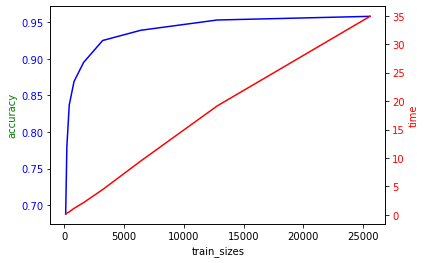

{100: {'accuracy': 0.688, 'time': 0.14899992942810059}, 200: {'accuracy': 0.78, 'time': 0.2950000762939453}, 400: {'accuracy': 0.837, 'time': 0.5360000133514404}, 800: {'accuracy': 0.869, 'time': 1.1389997005462646}, 1600: {'accuracy': 0.895, 'time': 2.1560001373291016}, 3200: {'accuracy': 0.925, 'time': 4.447999954223633}, 6400: {'accuracy': 0.939, 'time': 9.479999780654907}, 12800: {'accuracy': 0.953, 'time': 19.162999868392944}, 25600: {'accuracy': 0.958, 'time': 34.91000008583069}}
[0.688, 0.78, 0.837, 0.869, 0.895, 0.925, 0.939, 0.953, 0.958]


In [7]:
#def P3(train_sizes, accuracies):

### STUDENT START ###

def get_accuracy(train_size):
        """
        Evaluate accuracy and time for KNN-1 model with various size
        
        Args:
            train_size: traing data set
        
        Return:
            a dictionary showing accuracy and time needed for model training for given size
        """
        
        neighbors = KNeighborsClassifier(n_neighbors=1)
        index = np.random.choice(range(len(train_labels)), train_size)
        neighbors.fit(train_data[index],
                      train_labels[index])
        start_time = time.time()
        pred_labels = neighbors.predict(dev_data)
        time_total = time.time()-start_time
        correct_prediction = sum(pred_labels==dev_labels)
        accuracy = float(correct_prediction)/len(dev_labels)
        return {
            'accuracy': accuracy,
            'time': time_total
        }
    
def P3(train_sizes,accuracies):
    """
    Evaluate accuracy and time for KNN-1 model with various size
    
    Args:
        train_size: traing data set
        accuracies: default as an empty array
        
    Return:
        A dictionary of sizes as keys, and accuracies and time needed as values
    """
    
    accuracy_result = {size:get_accuracy(size) for size in train_sizes}
    fig, axis1 = plt.subplots()
    y_accuracy = sorted([value['accuracy'] for value in accuracy_result.values()])
    axis1.plot(train_sizes, y_accuracy, 'b-')
    axis1.set_xlabel('train_sizes')
    axis1.set_ylabel('accuracy', color='g')
    for label in axis1.get_yticklabels():
        label.set_color('b')
    axis2 = axis1.twinx()
    y_time = sorted([value['time'] for value in accuracy_result.values()])
    axis2.plot(train_sizes, y_time, 'r-')
    axis2.set_ylabel('time', color='r')
    for label in axis2.get_yticklabels():
        label.set_color('r')
    plt.show()
    return accuracy_result
    
train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25600]
accuracies = []
P3_result = P3(train_sizes, accuracies)

accuracies = sorted([value['accuracy'] for value in P3_result.values()])
print(P3_result)
print(accuracies)


### STUDENT END ###

#train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25600]
#accuracies = []
#P3(train_sizes, accuracies)

### Part 4:

Produce a linear regression model that predicts accuracy of a 1-Nearest Neighbor model given training set size. Show $R^2$ of the linear regression model.  Show the accuracies predicted for training set sizes 60000, 120000, and 1000000.  Show a lineplot of actual accuracies and predicted accuracies vs. training set size over the range of training set sizes in the training data.  What's wrong with using linear regression here?

Apply a transformation to the predictor features and a transformation to the outcome that make the predictions more reasonable.  Show $R^2$ of the improved linear regression model.  Show the accuracies predicted for training set sizes 60000, 120000, and 1000000.  Show a lineplot of actual accuracies and predicted accuracies vs. training set size over the range of training set sizes in the training data - be sure to display accuracies and training set sizes in appropriate units.

Notes:
* Train the linear regression models on all of the (transformed) accuracies estimated in Problem 3.
* Evaluate the linear regression models on all of the (transformed) accuracies estimated in Problem 3.
* You can use `LinearRegression` to produce a linear regression model.
* Remember that the sklearn `fit()` functions take an input matrix X and output vector Y. So, each input example in X is a vector, even if it contains only a single value.
* Hint re: predictor feature transform: Accuracy increases with training set size logarithmically.
* Hint re: outcome transform: When y is a number in range 0 to 1, then odds(y)=y/(1-y) is a number in range 0 to infinity.

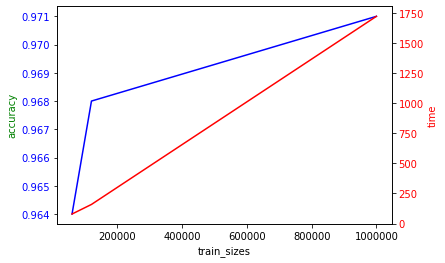

Accuracy for training size [60000, 120000, 1000000] is [0.9657689  0.9661105  0.97112061]



array([0.9657689 , 0.9661105 , 0.97112061])

In [8]:
#def P4():

### STUDENT START ###
def P4(training_sizes):
    """
    Evaluate accuracy  for KNN-1 model with various size
    
    Args:
        training_sizes: traing data set
        
    Return:
        Model accuracy
    """
    size = P3(training_sizes,[])
    accuracy = sorted([value['accuracy'] for value in size.values()])
    accuracy_array = np.array(accuracy)
    training_size_matrix = np.array(training_sizes).reshape((len(training_sizes),1))
    linear_regression = LinearRegression(fit_intercept=True)
    linear_regression.fit(training_size_matrix,accuracy_array) 
    prediction = linear_regression.predict(np.array(training_sizes).reshape(3,1))
    print (f'Accuracy for training size {training_sizes} is {prediction}\n')
    return prediction

training_sizes = [60000, 120000, 1000000]

P4(training_sizes)

### STUDENT END ###

#P4()

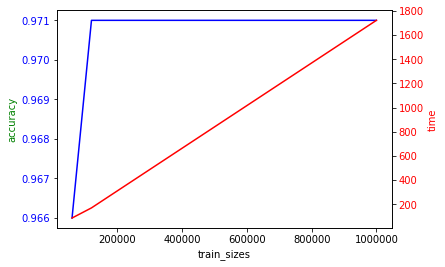

Accuracy for training size [60000, 120000, 1000000] is [0.96833028 0.96851083 0.97115888]



array([0.96833028, 0.96851083, 0.97115888])

In [9]:
def P4_with_transformation(training_sizes):
    """
    Evaluate accuracy  for KNN-1 model with various size with arcsine-square root transform
    
    Args:
        training_sizes: traing data set
        
    Return:
        Model accuracy
    """
    size = P3(training_sizes,[])
    accuracy = sorted([value['accuracy'] for value in size.values()])
    accuracy_array = np.arcsin(np.sqrt(accuracy))
    training_size_matrix = np.array(training_sizes).reshape((len(training_sizes),1))
    linear_regression = LinearRegression(fit_intercept=True)
    linear_regression.fit(training_size_matrix,accuracy_array) 
    prediction = np.power(np.sin(prediction),2)
    print (f'Accuracy for training size {training_sizes} after transformation is {prediction}\n')
    return prediction

training_sizes = [60000, 120000, 1000000]

P4(training_sizes)

### Part 5:

Produce a 1-Nearest Neighbor model and show the confusion matrix. Which pair of digits does the model confuse most often? Show the images of these most often confused digits.

Notes:
- Train on the mini train set.
- Evaluate performance on the dev set.
- You can use `confusion_matrix()` to produce a confusion matrix.

Confusion matrix is [[101   0   1   0   0   0   1   1   2   0]
 [  0 116   1   0   0   0   0   0   1   0]
 [  1   4  84   2   2   0   2   4   6   1]
 [  0   2   0  84   0   6   0   2   3   0]
 [  0   0   1   0  78   0   0   2   0  11]
 [  2   0   0   1   1  77   5   0   2   0]
 [  1   2   1   0   1   2  94   0   1   0]
 [  0   1   1   0   0   0   0  96   0   4]
 [  1   5   4   3   1   3   0   1  72   4]
 [  0   1   0   0   3   2   0   7   0  82]]


The most confused pair of digits are (4, 9)
Most confused pairs:



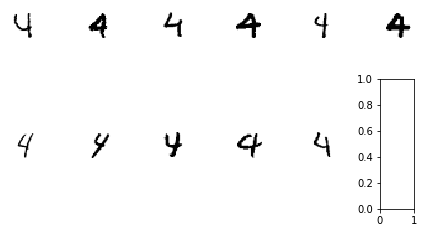

In [10]:
#def P5():

### STUDENT START ###
def P5(k):
    """
    Evaluation the confusion matrix for 1-Nearest Neighbor model .
    
    Args:
        k: number of neighbors for K nearest neighbor model.
    """
    neighbors = KNeighborsClassifier(n_neighbors=k)
    neighbors.fit(mini_train_data,mini_train_labels)
    predicted_labels = neighbors.predict(dev_data)
    conf_matrix = confusion_matrix(dev_labels,predicted_labels)  
    print (f'Confusion matrix is {conf_matrix}\n')
    np.fill_diagonal(conf_matrix,0)
    most_confused_pairs = np.unravel_index(np.argmax(conf_matrix),(10,10))
    print (f'\nThe most confused pair of digits are {most_confused_pairs}')
    index = np.intersect1d(np.where(dev_labels==str(most_confused_pairs[0])) ,
           np.where(predicted_labels ==str(most_confused_pairs[1])))

    figure, axes = plt.subplots(nrows=2,ncols=6)
    axes = axes.flatten()
    i = 0

    for index in index:
        data = dev_data[index].reshape(28,28)
        axes[i].imshow(data,cmap='Greys')
        axes[i].axis('off') 
        i += 1
    figure.tight_layout()
    print ('Most confused pairs:\n')
    plt.show()
    
P5(1)
### STUDENT END ###

#P5()

ANSWER: 

### Part 6:

A common image processing technique is to smooth an image by blurring. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian, i.e., the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.

Implement a simplified Gaussian blur filter by just using the 8 neighboring pixels like this: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values.

Pick a weight, then produce and evaluate four 1-Nearest Neighbor models by applying your blur filter in these ways:
- Do not use the filter
- Filter the training data but not the dev data
- Filter the dev data but not the training data
- Filter both training data and dev data

Show the accuracies of the four models evaluated as described.  Try to pick a weight that makes one model's accuracy at least 0.9.

Notes:
* Train on the (filtered) mini train set.
* Evaluate performance on the (filtered) dev set.
* There are other Guassian blur filters available, for example in `scipy.ndimage.filters`. You are welcome to experiment with those, but you are likely to get the best results with the simplified version described above.

In [11]:
#def P6():
    
### STUDENT START ###
from numpy.core import multiarray 

def get_blurred_pixel(color_data,row,col,r,sigma):
        """Calculate smoothed color intensity for a pixel
    
        Arges:
            color_data: color intensity data
            row: row of the pixel 
            colL: column of the pixel
            r: radius of pixels
            sigma: standard deviation of the Gaussian kernel
        Return:
            Blurred pixel

        """
        image =color_data[(row-r):(row+r+1),(col-r):(col+r+1)]
        distance = np.array(range(-1,1+1))
        dist_2d = [1/(2*3.14159*sigma**2)*np.exp(-(distance**2+y_dist**2)/(2*sigma**2)) for y_dist in distance]
        norm_g2d = dist_2d/np.sum(dist_2d)
        return np.mean(image*dist_2d/np.sum(dist_2d))
    
def blur_image(image,r,sigma):
    """
    Return Gaussian blurred image
    
    Args:
        image: image data
        r: radium
        sigma: sigma of Gaussian kernel
    
    Return:
        Return bluured images
    
    """
    
    image_dim = int(np.sqrt(len(image)))
    image_data = image.reshape(image_dim,image_dim)
    blurred_array = np.array([get_blurred_pixel(color_data=image_data,
              row=row,col=col,r=r,sigma=sigma)
          for row in range(r,image_dim-r) for col in range(r,image_dim-r)])
    return blurred_array
    
def P6(): 
    """
    Evaluate 1-Nearest Neighbor models with different filtering methods
    
    Returns:
        Classification reports for each filtering methods
    
    """   
    mini_train_data_blurred = [blur_image(record,r=1,sigma=0.333) 
                               for record in mini_train_data]
    dev_data_blurred =  [blur_image(record,r=1,sigma=0.333) 
                              for record in dev_data]
    mini_train_data_cropped = [img.reshape(28,28)[1:27,1:27].ravel() for img in mini_train_data]
    dev_data_cropped = [img.reshape(28,28)[1:27,1:27].ravel() for img in dev_data]
    
    # No filtering
    neighbors = KNeighborsClassifier(n_neighbors=1)
    neighbors.fit(mini_train_data_cropped,mini_train_labels)
    pred_labels = neighbors.predict(dev_data_cropped)
    print (f'No filter:\n {classification_report(dev_labels,pred_labels, digits=1)}')
    
    # Filtering mini training data
    neighbors = KNeighborsClassifier(n_neighbors=1)
    neighbors.fit(mini_train_data_blurred,mini_train_labels)
    pred_labels = neighbors.predict(dev_data_cropped)
    print (f'Filtering training data:\n{classification_report(dev_labels,pred_labels, digits=1)}')

    # Filtering dev data
    neighbors = KNeighborsClassifier(n_neighbors=1)
    neighbors.fit(mini_train_data_cropped,mini_train_labels)
    pred_labels = neighbors.predict(dev_data_blurred)
    print (f'Filtering dev data:\n {classification_report(dev_labels,pred_labels, digits=1)}')

    
    # Filtering both training data and dev data
    neighbors = KNeighborsClassifier(n_neighbors=1)
    neighbors.fit(mini_train_data_blurred,mini_train_labels)
    pred_labels = neighbors.predict(dev_data_blurred)
    print (f'Filtering both training data and dev data:\n {classification_report(dev_labels,pred_labels, digits=1)}')

P6()

### STUDENT END ###

#P6()

No filter:
               precision    recall  f1-score   support

           0        1.0       1.0       1.0       106
           1        0.9       1.0       0.9       118
           2        0.9       0.8       0.8       106
           3        0.9       0.9       0.9        97
           4        0.9       0.8       0.9        92
           5        0.9       0.9       0.9        88
           6        0.9       0.9       0.9       102
           7        0.8       0.9       0.9       102
           8        0.8       0.8       0.8        94
           9        0.8       0.9       0.8        95

   micro avg        0.9       0.9       0.9      1000
   macro avg        0.9       0.9       0.9      1000
weighted avg        0.9       0.9       0.9      1000

Filtering training data:
              precision    recall  f1-score   support

           0        0.6       1.0       0.7       106
           1        1.0       0.9       0.9       118
           2        0.9       0.5       0

C:\Users\sarahwang\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Filtering dev data:
               precision    recall  f1-score   support

           0        0.0       0.0       0.0       106
           1        0.1       1.0       0.2       118
           2        0.0       0.0       0.0       106
           3        0.0       0.0       0.0        97
           4        0.0       0.0       0.0        92
           5        0.0       0.0       0.0        88
           6        0.0       0.0       0.0       102
           7        0.0       0.0       0.0       102
           8        0.0       0.0       0.0        94
           9        0.0       0.0       0.0        95

   micro avg        0.1       0.1       0.1      1000
   macro avg        0.0       0.1       0.0      1000
weighted avg        0.0       0.1       0.0      1000

Filtering both training data and dev data:
               precision    recall  f1-score   support

           0        1.0       1.0       1.0       106
           1        0.9       1.0       0.9       118
           2 

### Part 7:

Produce two Naive Bayes models and evaluate their performances.  Recall that Naive Bayes estimates P(feature|label), where each label is a categorical, not a real number.

For the first model, map pixel values to either 0 or 1, representing white or black - you should pre-process the data or use `BernoulliNB`'s `binarize` parameter to set the white/black separation threshold to 0.1.  Use `BernoulliNB` to produce the model.

For the second model, map pixel values to either 0, 1, or 2, representing white, gray, or black - you should pre-process the data, seting the white/gray/black separation thresholds to 0.1 and 0.9.  Use `MultinomialNB` to produce the model. 

Show the Bernoulli model accuracy and the Multinomial model accuracy.

Notes:
* Train on the mini train set.
* Evaluate performance on the dev set.
* `sklearn`'s Naive Bayes methods can handle real numbers, but for this exercise explicitly do the mapping to categoricals. 

Does the multinomial version improve the results? Why or why not?

In [12]:
#def P7():

### STUDENT START ###

def map_data(data,threshold_1,threshold_2):
    """
    Map data to either 0, 1, or 2
    
    Args:
        data: data to be mapped
        threshold_1: data less than threshold_1 will be mapped as 0
        threshold_2: data greater than threshold_2 will be mapped as 2; data between threshold_1 and threshold_2 will be mapped as 1
    Return:
        Mapped data with value of either 0, 1, or 2
    """
    res = []
    for d in data:           
        if(d > threshold_2):
            res.append(2)
        elif(d > threshold_1 and d < threshold_2):
            res.append(1)
        else:
            res.append(0)
    return res

def P7():
    """
    Evaluation the results of Naive Bayes estimator using Bernoulli and Multinomial models.
    
    Return:
        Accuracy of Naive Bayes estimator using Bernoulli and Multinomial models
    
    """

    mapped_train_data =  [map_data(images,0,0.9) for images in train_data]
    mapped_dev_data =  [map_data(images,0,0.9) for images in dev_data]

    bernoulli1 = BernoulliNB(binarize=0.1)
    bernoulli1.fit(train_data, train_labels)

    multinomial_0_9 = MultinomialNB()
    multinomial_0_9.fit(mapped_train_data,train_labels)

    print (f'Bernoulli model at 0.1 accuracy: {bernoulli1.score(dev_data, dev_labels)}')
    print (f'Multinomial model at 0 and 0.90 accuracy: {multinomial_0_9.score(mapped_dev_data, dev_labels)}')

P7()

    
### STUDENT END ###

#P7()

Bernoulli model at 0.1 accuracy: 0.829
Multinomial model at 0 and 0.90 accuracy: 0.815


ANSWER: Based on the score, multinomial model does not improve the results

### Part 8:

Search across several values of the LaPlace smoothing parameter (alpha) to find its effect on a Bernoulli Naive Bayes model's performance.  Show the accuracy at each alpha value.

Notes:
* Set binarization threshold to 0.
* Train on the mini train set.
* Evaluate performance by 5-fold cross-validation. 
* Use `GridSearchCV(..., ..., cv=..., scoring='accuracy', iid=False)` to vary alpha and evaluate performance by cross-validation.
* Cross-validation is based on partitions of the training data, so results will be a bit different than if you had used the dev set to evaluate performance.

What is the best value for alpha? What is the accuracy when alpha is near 0? Is this what you'd expect?

In [13]:
#def P8(alphas):

### STUDENT START ###
def P8(alphas):
    """
    Search across several values of the LaPlace smoothing parameter (alpha) to find its effect on a Bernoulli Naive Bayes model's performance
    
    Args:
    
        alphas: value of the  smoothing hyperparameter.
            
    Returns: 
        Best fit of the Bernoulli NB model. 
    
    """
    bernoulli0 = BernoulliNB(binarize=0)
    bernoulli0_cv = GridSearchCV(bernoulli0,alphas)
    fit = bernoulli0_cv.fit(train_data, train_labels)

    bernoulli0_alpha0 = BernoulliNB(alpha=0,binarize=0)
    bernoulli0_alpha0.fit(train_data, train_labels)
    pred_labels = bernoulli0_alpha0.predict(dev_data)    
    return fit

alphas = {'alpha': [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
nb = P8(alphas)
print(f'Best alpha = {nb.best_params_}' )

### STUDENT END ###

# alphas = {'alpha': [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
# nb = P8(alphas)
# print()
# print("Best alpha = ", nb.best_params_)

C:\Users\sarahwang\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Best alpha = {'alpha': 1e-10}


C:\Users\sarahwang\anaconda3\lib\site-packages\sklearn\naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


ANSWER: The best alpha is 1e-10

### Part 9:

Produce a model using Guassian Naive Bayes, which is intended for real-valued features, and evaluate performance. You will notice that it does not work so well. Diagnose the problem and apply a simple fix so that the model accuracy is around the same as for a Bernoulli Naive Bayes model. Show the model accuracy before your fix and the model accuracy after your fix.  Explain your solution.

Notes:
* Train on the mini train set.
* Evaluate performance on the dev set.
* Consider the effects of theta and sigma.  These are stored in the model's `theta_` and `sigma_` attributes.

In [14]:
#def P9(): 

### STUDENT END ###
def P9():
    """
    Produce a model using Guassian Naive Bayes, and improved the accuracy
    """
    
    gaussian = GaussianNB()
    gaussian.fit(train_data, train_labels)
    predicted_labels = gaussian.predict(dev_data)
    print (f'Gaussian Naive Bayes results \n {classification_report(dev_labels,predicted_labels)}')

    print (f'theta is \n {gaussian.theta_}\n sigma is \n {gaussian.sigma_}\n')

    blurred_data_ = gaussian_filter(train_data,sigma=1)
    blurred_gaussian = GaussianNB()
    blurred_gaussian.fit(blurred_data_, train_labels)
    blurred_predicted_labels = blurred_gaussian.predict(dev_data)
    print (f'Gaussian Naive Bayes results with blurred training data\n {classification_report(dev_labels,blurred_predicted_labels)}')

    additional_noise = []
    for i in range(len(train_data)):
        additional_noise.append(np.random.normal(0,0.1,28*28))
    noise_data = train_data+additional_noise

    noise_gaussian = GaussianNB()
    noise_gaussian.fit(noise_data, train_labels)
    noise_predicted_labels = noise_gaussian.predict(dev_data)
    print (f'Gaussian Naive Bayes results with random noise added training data\n {classification_report(dev_labels,noise_predicted_labels)}')

gnb = P9()  

### STUDENT END ###

#P9()

Gaussian Naive Bayes results 
               precision    recall  f1-score   support

           0       0.79      0.92      0.85       106
           1       0.83      0.92      0.88       118
           2       0.89      0.23      0.36       106
           3       0.73      0.38      0.50        97
           4       0.93      0.28      0.43        92
           5       0.79      0.12      0.22        88
           6       0.61      0.92      0.73       102
           7       0.91      0.40      0.56       102
           8       0.27      0.60      0.37        94
           9       0.42      0.96      0.58        95

   micro avg       0.59      0.59      0.59      1000
   macro avg       0.72      0.57      0.55      1000
weighted avg       0.72      0.59      0.56      1000

theta is 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
 sigma is 
 [[1.99408716e-10 1.99408716e-10

ANSWER: The Gaussian Naive Bayes model does not have as accurate results as the Bernoulli Naive Bayes model, caused by a large number of zero color intensities. As shown by the estimated parameters, all coefficients and standard deviations are estimated to be zero. 

### Part 10:

Because Naive Bayes produces a generative model, you can use it to generate digit images.

Produce a Bernoulli Naive Bayes model and then use it to generate a 10x20 grid with 20 example images of each digit. Each pixel output should be either 0 or 1, based on comparing some randomly generated number to the estimated probability of the pixel being either 0 or 1.  Show the grid.

Notes:
* You can use np.random.rand() to generate random numbers from a uniform distribution.
* The estimated probability of each pixel being 0 or 1 is stored in the model's `feature_log_prob_` attribute. You can use `np.exp()` to convert a log probability back to a probability.

How do the generated digit images compare to the training digit images?

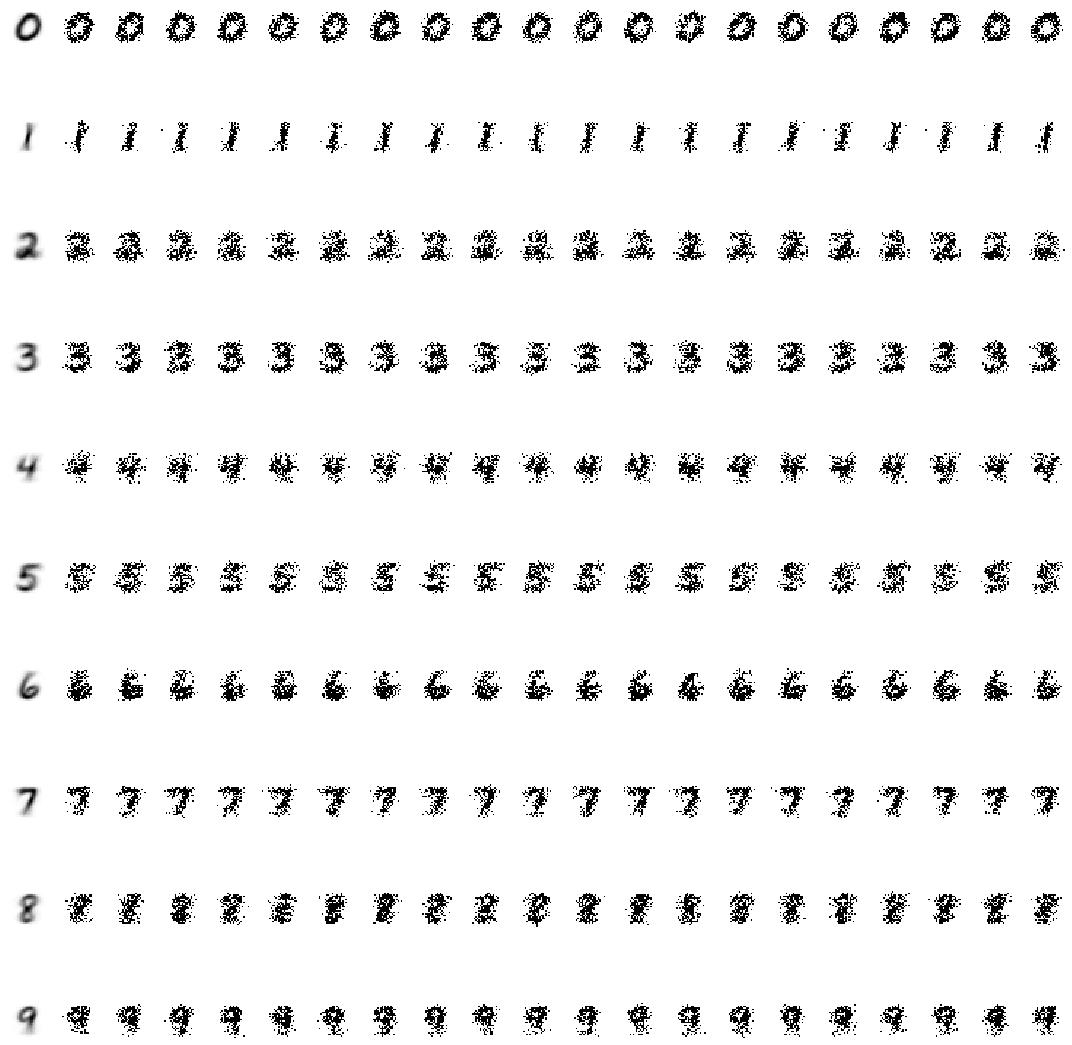

In [15]:
#def P10(num_examples):

### STUDENT START ###

def get_digit(data,labels,digit):
    """
    Get digit from data array
    
    Args:
        data: data input
        label: label input
        digit: digit to be found in the data array
        
    Return:
        return matched digit
    """
    idx = np.where(labels==str(digit))
    color =reduce(lambda img1,img2: img1+img2, 
                          data[idx])/len(idx)
    return color

    
def P10(num_examples):
    """
    Use Bernoulli Naive Bayes model to generate a 10x20 grid with 20 example images of each digit
    
    Args:
        num_example: number of example images of each digit
    
    Return: 
        A 10x20 grid with 20 example images of each digit
    """
    bernoulli_model = BernoulliNB(alpha=1e-6,binarize=0)
    bernoulli_model.fit(mini_train_data, mini_train_labels)
    fig, axes = plt.subplots(nrows=10,
                             ncols=num_examples+1,
                             figsize=(15,16))
    for d in range(10):
        for n in range(num_examples+1):
            if(n is 0):
                data = get_digit(mini_train_data,mini_train_labels,d)
            else:                
                data = (np.exp(bernoulli_model.feature_log_prob_)[d]>np.random.rand(784))
            axes[d][n].imshow(data.reshape(28,28),cmap='Greys')
            axes[d][n].axis('off') # reduce the clutter around the images
            axes[d][n].get_xaxis().set_visible(False) # reduce the whitespace
            axes[d][n].get_yaxis().set_visible(False) # between the subplots
            
                
    fig.tight_layout()
    plt.show()


P10(20)

### STUDENT END ###

#P10(20)

ANSWER: First column in the above graph is the average color intensities for each digit of the training data set.
    Rest of the columns are examples of the simulated digits. Training set's digits are much smoother than the generated digits

### Part 11:

Recall that a strongly calibrated classifier is rougly 90% accurate when the posterior probability of the predicted class is 0.9. A weakly calibrated classifier is more accurate when the posterior probability of the predicted class is 90% than when it is 80%. A poorly calibrated classifier has no positive correlation between posterior probability and accuracy.  

Produce a Bernoulli Naive Bayes model.  Evaluate performance: partition the dev set into several buckets based on the posterior probabilities of the predicted classes - think of a bin in a histogram- and then estimate the accuracy for each bucket. So, for each prediction, find the bucket to which the maximum posterior probability belongs, and update "correct" and "total" counters accordingly.  Show the accuracy for each bucket.

Notes:
* Set LaPlace smoothing (alpha) to the optimal value (from part 8).
* Set binarization threshold to 0.
* Train on the mini train set.
* Evaluate perfromance on the dev set.

How would you characterize the calibration for this Bernoulli Naive Bayes model?

In [16]:
#def P11(buckets, correct, total):
    
### STUDENT START ###

def P11(buckets,alpha=1,threshold=0):
    # fit model
    bernoulli = BernoulliNB(alpha=alpha,binarize=threshold)
    bernoulli.fit(train_data, train_labels)
    posterior_probability = bernoulli.predict_proba(dev_data)
                
### STUDENT END ###

buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
correct = [0 for i in buckets]
total = [0 for i in buckets]

P11(buckets, correct, total)

for i in range(len(buckets)):
    accuracy = 0.0
    if (total[i] > 0): accuracy = correct[i] / total[i]
    print('p(pred) is %.13f to %.13f    total = %3d    accuracy = %.3f' % (0 if i==0 else buckets[i-1], buckets[i], total[i], accuracy))

ValueError: operands could not be broadcast together with shapes (60000,784) (9,) 

In [ ]:
bernoulli = BernoulliNB(alpha=1,binarize=0)
bernoulli.fit(train_data, train_labels)
posterior_probs = bernoulli.predict_proba(dev_data)
# find maximum posterior and predicted label
posterior_max,pred_labels =zip(*map(lambda posterior_prob: (posterior_prob.max(),
                               posterior_prob.argmax()),posterior_probs))  
total = np.histogram(posterior_max,[0]+buckets)[0]
binned_posterior = np.digitize(posterior_max,buckets,right=True)
total = np.bincount(binned_posterior)
correct_label = pred_labels == dev_labels
correct = map(lambda bucket: sum(correct_label[np.where(bucket==binned_posterior)]),
                     np.arange(np.max(binned_posterior)+1))
cumsum_correct,cumsum_total = np.add.accumulate(correct),np.add.accumulate(total)
#accuracy = cumsum_correct.astype(float)/cumsum_total

In [ ]:
correct_label[np.where(binned_posterior==3)]

In [ ]:
binned_posterior

ANSWER:

### Part 12 EXTRA CREDIT:

Design new features to see if you can produce a Bernoulli Naive Bayes model with better performance.  Show the accuracy of a model based on the original features and the accuracy of the model based on the new features.

Here are a few ideas to get you started:
- Try summing or averaging the pixel values in each row.
- Try summing or averaging the pixel values in each column.
- Try summing or averaging the pixel values in each square block. (pick various block sizes)
- Try counting the number of enclosed regions. (8 usually has 2 enclosed regions, 9 usually has 1, and 7 usually has 0)

Notes:
* Train on the mini train set (enhanced to comprise the new features).
* Evaulate performance on the dev set.
* Ensure that your code is well commented.

In [ ]:
#def P12():

### STUDENT START ###


### STUDENT END ###

#P12()